In [68]:
import numpy as np
from os.path import expanduser
import os
import json
import theano
import pyret.filtertools as ft
import pyret.visualizations as pyviz
#import deepretina.visualizations as viz
import preprocessing
from preprocessing import datagen, loadexpt
from utils import rolling_window
from keras.models import model_from_json
import h5py
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
%matplotlib inline
#%matplotlib qt

from pylab import rcParams
rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
rcParams['image.interpolation'] = 'nearest'
rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load full STC of the experiment  
This is the normalized STC with (STA)(STA)^T subtracted

In [2]:
path_to_stc = '/Users/lmcintosh/Dropbox/deep-retina/saved/lenna.salamander/2015-12-04 10.26.59 Experiment STC/'
stc_filename = 'full_stc_experiment_15_10_07.h5'
f = h5py.File(os.path.join(path_to_stc, stc_filename), 'r')

In [3]:
list(f)

[u'stc']

In [4]:
stc = f['stc']

In [5]:
stc.shape

(4235, 4235)

In [6]:
u,v = np.linalg.eigh(stc)

In [7]:
(u.shape, v.shape)

((4235,), (4235, 4235))

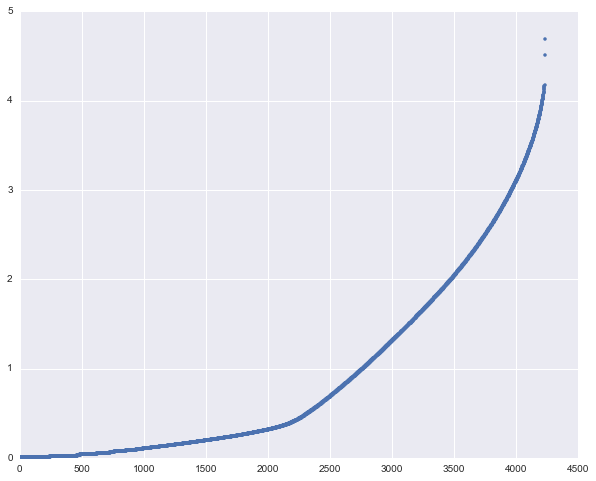

In [9]:
plt.plot(u, '.')

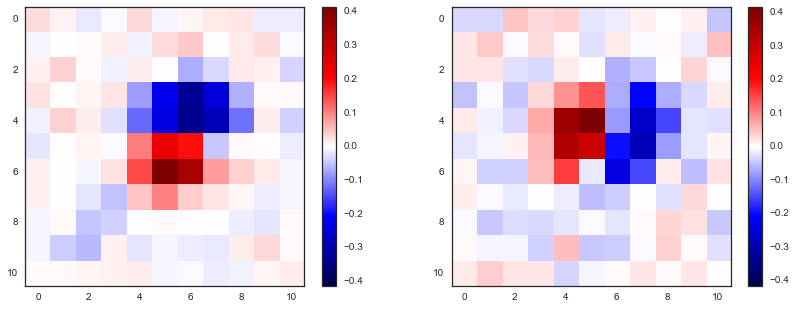

In [33]:
fig = plt.gcf()
fig.set_size_inches((14,5))
plt.subplot(1,2,1)
space, time = ft.decompose(v[:,-1].reshape((35,11,11)))
plt.imshow(space, interpolation='nearest', cmap='seismic', clim=[-np.max(np.abs(space)), np.max(np.abs(space))])
plt.colorbar()

plt.subplot(1,2,2)
space, time = ft.decompose(v[:,-2].reshape((35,11,11)))
plt.imshow(space, interpolation='nearest', cmap='seismic', clim=[-np.max(np.abs(space)), np.max(np.abs(space))])
plt.colorbar()

# Compute STC of CNN

In [5]:
whitenoise_train = loadexpt(0, 'whitenoise', 'train', 40, roll=False)

Loading training data... Done.


In [3]:
architecture_filename = 'architecture.json'
whitenoise_data_dir = '/Users/lmcintosh/Dropbox/deep-retina/saved/lenna.salamander/2015-11-08 15.42.33 convnet/'
whitenoise_weight_filename = 'epoch018_iter01300_weights.h5' # .63 cc on held-out

whitenoise_architecture_data = open(whitenoise_data_dir + architecture_filename, 'r')
whitenoise_architecture_string = whitenoise_architecture_data.read()
whitenoise_model = model_from_json(whitenoise_architecture_string)
whitenoise_model.load_weights(whitenoise_data_dir + whitenoise_weight_filename)

In [10]:
whitenoise_train.X.shape

(359802, 50, 50)

In [11]:
np.mean(whitenoise_train.y)

7.1536721965425132

In [12]:
np.std(whitenoise_train.y)

17.963241871749414

#### True firing rate of the cell is:

In [14]:
100 * (25761./whitenoise_train.y.shape[0])

7.160567263913364

In [15]:
? np.where

In [64]:
model_spikes = np.where(whitenoise_train.y > 2.22*np.std(whitenoise_train.y), 1, 0)

In [65]:
np.sum(model_spikes)

27618

In [66]:
100. * (1.*np.sum(model_spikes)/whitenoise_train.y.shape[0])

7.676741845998188

In [67]:
len(model_spikes)

359762

### Load real times of stimulus and get time stamps of model spikes

In [69]:
f = h5py.File(os.path.join(preprocessing.datadirs['lane.local'], '15-10-07/whitenoise.h5'), 'r')

In [70]:
f['train/time'].shape

(359802,)

In [71]:
time = np.array(f['train/time'][40:])

In [72]:
time.shape

(359762,)

In [73]:
model_spike_times = np.where(whitenoise_train.y > 2.22*np.std(whitenoise_train.y), time, -1)

In [74]:
model_spike_times = model_spike_times[model_spike_times >= 0]

In [75]:
len(model_spike_times)

27618

In [84]:
time.shape

(359762,)

In [85]:
whitenoise_train.X.shape

(359802, 50, 50)

In [86]:
sta, tax = ft.getsta(time, whitenoise_train.X[40:], model_spike_times, 40)

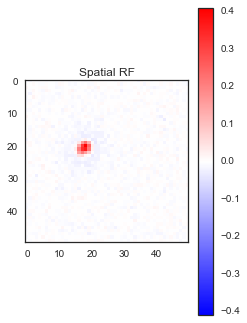

(<matplotlib.figure.Figure at 0x11f728b10>,
 (<matplotlib.axes._subplots.AxesSubplot at 0x11f74b450>,
  <matplotlib.axes._subplots.AxesSubplot at 0x11f46fc90>))

In [87]:
pyviz.plotsta(tax, sta)

### Alternatively, let's try setting time to be exactly increments of 10 ms

In [83]:
len(whitenoise_train.X)

359802

In [ ]:
time = np.linspace(0,0.01*len(whitenoise_train.y))

In [ ]:
model_spike_times = np.where(whitenoise_train.y > 2.22*np.std(whitenoise_train.y), time, -1)